In [125]:
import fitz  # Import the PyMuPDF library
import pandas as pd
pd.set_option('mode.copy_on_write', True)
import re
import os
import glob
import spacy
nlp = spacy.load("en_core_web_sm") 
from spacy.matcher import Matcher
lemmatizer = nlp.get_pipe("lemmatizer")
import datetime
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
import json
import numpy as np
import seaborn as sns
from scipy.spatial import distance
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as sm
import pingouin as pg
from math import sqrt

In [4]:
#Import Civil Service Job Adverts
# Path to the folder containing CSV files
path = "/Users/markrichardson-griffiths/Documents/Masters/Capstone/Data/Civil Service Jobs/"

# List all files in the folder
files = os.listdir(path)

# Initialize an empty list to store references to each batch of jobs batches (DataFrames)
job_batches = []

# Loop through each CSV file and read it into a DataFrame
for file in files:
    if file in ".DS_Store":
        continue
    else:
        file_path = path + file
        df_job_batch = pd.read_csv(file_path)
        job_batches.append(df_job_batch)

# Concatenate all job batches
df_all_jobs = pd.concat(job_batches, ignore_index=True)

In [5]:
#For info. count number of vacancies
print(len(df_all_jobs))

6373


In [6]:
#Reusable function to get most recent file

def identify_most_recent_file(path, base):
  
    pattern = os.path.join(path, f'{base}*.csv')
    csv_files = glob.glob(pattern)
    latest_file = max(csv_files, key=os.path.getmtime)
    return latest_file


In [7]:
#Import literature and store for pre-processing

path = "/Users/markrichardson-griffiths/Documents/Masters/Capstone/Data/Expert_Corpus/Consolidated/"
base = 'consolidated_lit'
file = identify_most_recent_file(path, base)
df_lit_docs = pd.read_csv(file) 

In [8]:
#Carry out preprocessing

#Remove duplicate jobs
df_unique_jobs = df_all_jobs.drop_duplicates(subset=['ref_no'], keep='last')

#Remove non-white space, non-characters and formatting such as /n from jobs
def remove_noise(text):
     return re.sub(r'[^\w\s]', '', text).replace('\n', ' ').replace('\xa0', ' ').replace('About the job Job', '').replace('summary', '')

df_unique_jobs['about_the_job'] = df_unique_jobs['about_the_job'].apply(remove_noise)

In [9]:
#For info - count unique jobs/vacancies
print(f"The number of jobs being analysed is: {len(df_unique_jobs)}")

The number of jobs being analysed is: 2051


In [10]:
#Bring the two corpuses together
two_corpus = []

for index, row in df_lit_docs.iterrows():
    two_corpus.append(row['Raw Text'])

for index, row in df_unique_jobs.iterrows():
    two_corpus.append(row['about_the_job'])

#Create a corresponding list to track the document types
doc_types = ['literature'] * len(df_lit_docs) + ['vacancies'] * len(df_unique_jobs)

In [11]:
# Initialize the Matcher with the skills patterns
file_path_patterns = file_path = '/Users/markrichardson-griffiths/Documents/Masters/Capstone/Data/Patterns/patterns_skills.json'

# Load JSON file containing patterns
with open(file_path_patterns, "r") as json_file:
    patterns_data = json.load(json_file)

# Create a Matcher object
matcher = Matcher(nlp.vocab)

for pattern_entry in patterns_data:
    label = pattern_entry.get("label")
    pattern = pattern_entry.get("pattern")
    
    matcher.add(label, [pattern])

In [12]:
#Carry out vectorisation
#Load the features identified in the skills_ID code
path = "/Users/markrichardson-griffiths/Documents/Masters/Capstone/Data/Outputs/"
pattern = 'Skill_Phrases_All'

file = identify_most_recent_file(path, pattern)
df_previous_tfidf = pd.read_csv(file) 

features = df_previous_tfidf.columns
features_lwr = [feature.lower() for feature in features]

chunk_size = 10_000  

def custom_tokenizer(long_text):
    list_NP_surface_form=[]
    # Process the text in chunks
    chunks = [long_text[i:i+chunk_size] for i in range(0, len(long_text), chunk_size)]
    for chunk in chunks:
        docs = nlp(chunk)
        matches = matcher(docs)
        for match_id, match_start, match_end in matches: 
            noun_phrase = docs[match_start:match_end]
            lemmatized_NP = ' '.join(token.lemma_ for token in noun_phrase)
            list_NP_surface_form.append(lemmatized_NP)
    return(list_NP_surface_form)

tfidf = TfidfVectorizer(tokenizer = custom_tokenizer, vocabulary=features_lwr, input = 'content', strip_accents = 'ascii', stop_words = 'english', max_features=400)
tfidf_matrix_two_corpuses = tfidf.fit_transform(two_corpus)

#Use L2 Normalisation
tfidf_matrix_l2 = normalize(tfidf_matrix_two_corpuses, norm='l2')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [13]:
#Convert to dense matrices
dense_matrix_tfidf = tfidf_matrix_l2.todense().tolist() 
#Get feature names
feature_names = tfidf.get_feature_names_out()

df_tfidf_results_ungrouped = pd.DataFrame(dense_matrix_tfidf,columns=feature_names)
#df_tfidf_results_ungrouped.index = ['Literature', 'Vacancies']
df_tfidf_results_ungrouped.reset_index(inplace=True)
df_tfidf_results_ungrouped.set_index(pd.Index(doc_types), inplace=True)

#Store results
path = "/Users/markrichardson-griffiths/Documents/Masters/Capstone/Data/Outputs/"
current_datetime = datetime.datetime.now()

df_tfidf_results_ungrouped.to_csv(path + 'Two_Corpuses_Ungrouped' + str(current_datetime) + '.csv', index=True)

In [14]:
#Retrieve the skills we're tracking
path = "/Users/markrichardson-griffiths/Documents/Masters/Capstone/Data/Outputs/"
pattern = 'Skills_for_tracking'

file = identify_most_recent_file(path, pattern)
df_skills_for_tracking = pd.read_csv(file) 

#Convert into a list
list_skills_for_tracking = df_skills_for_tracking["mapped skill"].tolist() 

In [15]:
#Create a dictionary object from the skill groups manually identified and mapped
path = "/Users/markrichardson-griffiths/Documents/Masters/Capstone/Data/Skill Groupings/"

skill_mapping = pd.read_excel(path + "skill_groupings.xlsx")

dict_skill_groupings = {}

#Build-up the dictionary holding only the skills we are tracking
for index, row in skill_mapping.iterrows():
    key = row['Key']
    value = row['Values']
   
    if key in list_skills_for_tracking: #Place it in the dictionary
        if key in dict_skill_groupings:
            dict_skill_groupings[key].append(value)
        else:
            dict_skill_groupings[key] = [value]
    else:
        continue

In [16]:
#Group Tf-IDF features by higher level skill 

path = "/Users/markrichardson-griffiths/Documents/Masters/Capstone/Data/Outputs/"
pattern = 'Two_Corpuses_Ungrouped'

file = identify_most_recent_file(path, pattern)

df_tfidf_results_ungrouped = pd.read_csv(file, index_col=0)

doc_type=[]
feature=[]
mapped_skill=[]
tfidf_results=[]

for col_name, col_data in df_tfidf_results_ungrouped.items():
    doc_type.extend(col_data.index)
    feature.extend([col_name] * len(col_data.values)) #Hold the unmapped feature
    tfidf_results.extend(col_data.values)

#Get at the higher-level skill
    match = False
    for key, value in dict_skill_groupings.items():
        if col_name in value:
            mapped_skill.extend([key] * len(col_data.values))
            match = True
            break
        else:
            continue
    if match != True:
        mapped_skill.extend(['Not Mapped'] * len(col_data.values))

#Store as a DataFrame

data = {'doc_type': doc_type,
        'feature': feature,
        'mapped skill': mapped_skill,
        'tf_idf': tfidf_results
        }

df_tfidf_mapped = pd.DataFrame(data)

df_tfidf_mapped.drop('feature', axis=1, inplace=True)

#Remove the high-level skills that we are not tracking
boolean_mask = df_tfidf_mapped['mapped skill'] != 'Not Mapped' 
df_tfidf_mapped = df_tfidf_mapped[boolean_mask] 

In [17]:
#Store results
path = "/Users/markrichardson-griffiths/Documents/Masters/Capstone/Data/Outputs/"
current_datetime = datetime.datetime.now()

df_tfidf_mapped.to_csv(path + 'two_corpuses_tfidf_mapped' + str(current_datetime) + '.csv', index=True)

In [18]:
#Calculate the Tf-IDF Means

path = "/Users/markrichardson-griffiths/Documents/Masters/Capstone/Data/Outputs/"
pattern = 'two_corpuses_tfidf_mapped'

file = identify_most_recent_file(path, pattern)

df_tfidf_grouped_by_skill = pd.read_csv(file, index_col=0)

# Split the DataFrame by lit Vs Vacancies
df_lit = df_tfidf_grouped_by_skill[df_tfidf_grouped_by_skill['doc_type'] == 'literature'].drop(columns='doc_type')
df_vacancies = df_tfidf_grouped_by_skill[df_tfidf_grouped_by_skill['doc_type'] == 'vacancies'].drop(columns='doc_type')

# Calculate the average TF-IDF scores for each high level skill
means_lit = df_lit.groupby(['mapped skill']).mean()
means_vacancies = df_vacancies.groupby(['mapped skill']).mean()

In [18]:
#Transpose and Combine the two dataframes for heatmap presentation
means_lit_t = means_lit.T
means_vacancies_t = means_vacancies.T

# Combine the DataFrames
combined_df = pd.concat([means_lit_t, means_vacancies_t], ignore_index=True)
combined_df.index=['Expert Opinion', 'Vacancies']

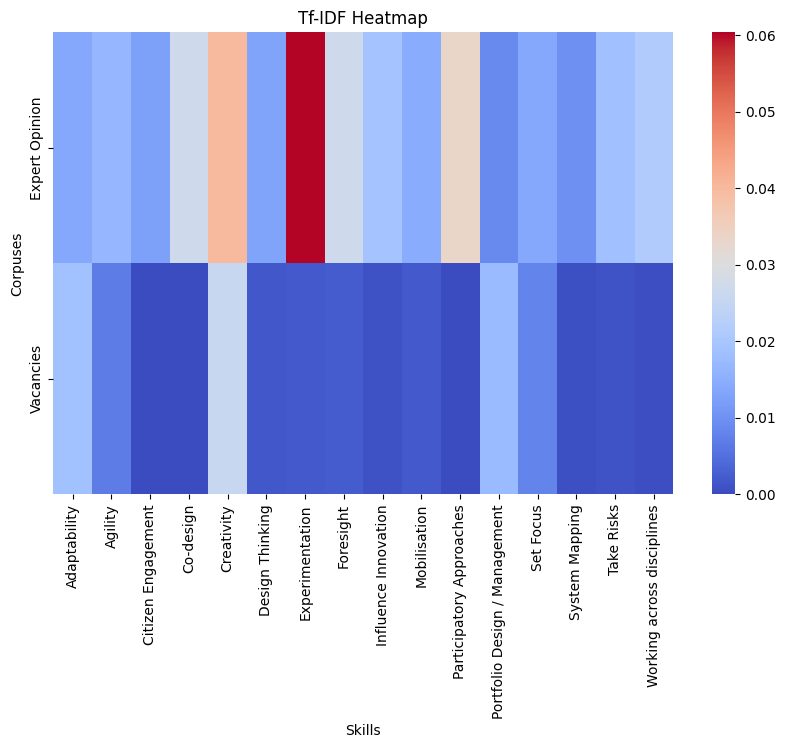

In [23]:
# Create a heatmap (1)

plt.figure(figsize=(10, 6))
sns.heatmap(combined_df, annot=False, fmt=".2f", cmap="coolwarm", xticklabels=combined_df.columns) 
plt.xlabel("Skills")
plt.ylabel("Corpuses")
plt.title("Tf-IDF Heatmap")
plt.show()

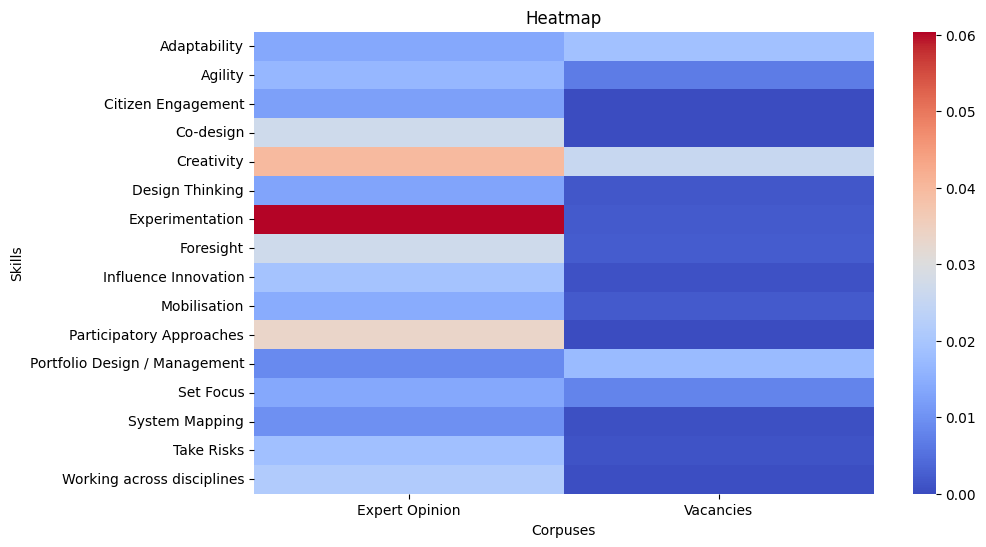

In [24]:
#Create a heatmpa (2) - Transpose the data such that skills are on the y axis

plt.figure(figsize=(10, 6))
sns.heatmap(combined_df.T, annot=False, fmt=".2f", cmap="coolwarm", xticklabels=combined_df.index, yticklabels=combined_df.columns) 
plt.xlabel("Corpuses")
plt.ylabel("Skills")
plt.title("Heatmap")
plt.show()

In [122]:
#Run independent T-Tests
df_data = pd.DataFrame(data)

df_data = df_data[df_data['mapped skill'] != 'Not Mapped']

mapped_skills = df_data['mapped skill'].unique()

#To store t-test results
results_mapped_skills = []
results_ttest = []

for mapped_skill in mapped_skills:
    
    x_values = []
    y_values = []

    x_values = df_data[(df_data['mapped skill'] == mapped_skill) & (df_data['doc_type'] == 'literature')]['tf_idf'].tolist()
    y_values = df_data[(df_data['mapped skill'] == mapped_skill) & (df_data['doc_type'] == 'vacancies')]['tf_idf'].tolist()
    
    # Perform independent t-test
    ttest_result = pg.ttest(
        x = x_values,
        y = y_values,
        paired = False
    )

    #Store results
    results_mapped_skills.append(mapped_skill)
    results_ttest.append(ttest_result['p-val'].iloc[0])

#Store as dataframe for presentation
results = {
    'mapped skill': results_mapped_skills,
    'p_val': results_ttest
}

ttest_results = pd.DataFrame(data = results)

ttest_results = ttest_results.sort_values(by='mapped skill')

# Set display option
#pd.set_option('display.float_format', '{:.6f}'.format)
pd.reset_option('display.float_format')

print(ttest_results)

                     mapped skill         p_val
2                    Adaptability  1.047353e-01
4                         Agility  1.205935e-01
5              Citizen Engagement  2.585378e-04
6                       Co-design  1.962904e-05
7                      Creativity  9.823773e-02
9                 Design Thinking  3.024513e-01
10                Experimentation  1.481714e-09
11                      Foresight  2.582950e-03
1            Influence Innovation  5.407954e-09
12                   Mobilisation  1.910331e-03
13       Participatory Approaches  7.327912e-04
8   Portfolio Design / Management  7.485964e-05
0                       Set Focus  5.303156e-03
15                 System Mapping  6.693054e-02
14                     Take Risks  8.157279e-03
3      Working across disciplines  7.011463e-04


In [124]:
# Apply Bonferroni correction
num_tests = len(ttest_results)
ttest_results['p_val_corrected'] = ttest_results['p_val'] * num_tests

# Ensure p-values do not exceed 1
ttest_results['p_val_corrected'] = ttest_results['p_val_corrected'].clip(upper=1.0)

# Sort by 'mapped skill'
ttest_results = ttest_results.sort_values(by='mapped skill')

# Set display option 
#pd.set_option('display.float_format', '{:.6f}'.format)
pd.reset_option('display.float_format')
print(ttest_results)

                     mapped skill         p_val  p_val_corrected
2                    Adaptability  1.047353e-01     1.000000e+00
4                         Agility  1.205935e-01     1.000000e+00
5              Citizen Engagement  2.585378e-04     4.136605e-03
6                       Co-design  1.962904e-05     3.140647e-04
7                      Creativity  9.823773e-02     1.000000e+00
9                 Design Thinking  3.024513e-01     1.000000e+00
10                Experimentation  1.481714e-09     2.370743e-08
11                      Foresight  2.582950e-03     4.132721e-02
1            Influence Innovation  5.407954e-09     8.652726e-08
12                   Mobilisation  1.910331e-03     3.056530e-02
13       Participatory Approaches  7.327912e-04     1.172466e-02
8   Portfolio Design / Management  7.485964e-05     1.197754e-03
0                       Set Focus  5.303156e-03     8.485049e-02
15                 System Mapping  6.693054e-02     1.000000e+00
14                     Ta

In [118]:
#Identify significant results

# # Set significance threshold
sig = 0.05

# Filter results to only include significant p-values
significant_results = ttest_results[ttest_results['p_val_corrected'] <= sig]

# Sort by 'mapped skill'
significant_results = significant_results.sort_values(by='mapped skill')

# Reset display option
pd.reset_option('display.float_format')

# Print significant results
print(significant_results)

                     mapped skill         p_val  p_val_corrected
5              Citizen Engagement  2.585378e-04     4.136605e-03
6                       Co-design  1.962904e-05     3.140647e-04
10                Experimentation  1.481714e-09     2.370743e-08
11                      Foresight  2.582950e-03     4.132721e-02
1            Influence Innovation  5.407954e-09     8.652726e-08
12                   Mobilisation  1.910331e-03     3.056530e-02
13       Participatory Approaches  7.327912e-04     1.172466e-02
8   Portfolio Design / Management  7.485964e-05     1.197754e-03
3      Working across disciplines  7.011463e-04     1.121834e-02


In [131]:
#Calculate Cohen's d effect size - difference between the two means / pooled standard deviation

mapped_skills = significant_results['mapped skill'].unique() #Unique list of higher-level skills

skills = []
effect_sizes = []

for mapped_skill in mapped_skills:
    
    group_lit = df_data[(df_data['mapped skill'] == mapped_skill) & (df_data['doc_type'] == 'literature')]['tf_idf'].tolist()
    group_vac = df_data[(df_data['mapped skill'] == mapped_skill) & (df_data['doc_type'] == 'vacancies')]['tf_idf'].tolist()
    
    mean_lit, mean_vac = np.mean(group_lit), np.mean(group_vac)
    std_lit, std_vac = np.std(group_lit), np.std(group_vac) 
    
    n_lit, n_vac = len(group_lit), len(group_vac)

    # Pooled standard deviation
    pooled_std = sqrt(((n_lit - 1) * std_lit**2 + (n_vac - 1) * std_vac**2) / (n_lit + n_vac - 2))

    #Calculate and store effect sizes
    cohen_d = (mean_lit - mean_vac) / pooled_std

    skills.append(mapped_skill)
    effect_sizes.append(cohen_d)

#Store as dataframe for presentation
results = {
    'skill': skills,
    'effect size': effect_sizes
}

effect_sizes = pd.DataFrame(data = results)

effect_sizes = effect_sizes.sort_values(by='effect size', ascending=False)

print(effect_sizes)


                           skill  effect size
1                      Co-design     2.657792
6       Participatory Approaches     2.565145
0             Citizen Engagement     2.248650
2                Experimentation     1.504032
8     Working across disciplines     0.774925
4           Influence Innovation     0.747205
3                      Foresight     0.575555
5                   Mobilisation     0.339238
7  Portfolio Design / Management    -0.087714
